In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import seaborn as sns

In [2]:
df = pd.read_csv('Aircraft_Noise_Exceedances_20241209.csv')
df.head()

,location_id,corr_id,max_date_time,classification,sel,max_level,duration,day_night,operation_no,flight_date_time,operation_type,runway_name,aircraft_type,aircraft_category,airline_code,airline,other_port,airport_code,data_as_of,data_loaded_at
0,12,20519073,2024/04/16 11:13:21 PM,1,80.3,70.4,22,Night,42142833.0,2024-04-16 23:17:49,A,28R,B739,J,DAL,DELTA AIR LINES,ATL,SFO,2024/05/29 03:32:10 PM,2024/11/26 06:23:28 AM
1,12,20519139,2024/04/17 12:10:23 AM,1,80.2,71.3,18,Night,42143007.0,2024-04-17 00:15:37,A,28R,A21N,J,DAL,DELTA AIR LINES,BOS,SFO,2024/05/29 03:32:10 PM,2024/11/26 06:23:28 AM
2,12,20519137,2024/04/17 12:51:45 AM,1,79.8,70.3,21,Night,42143004.0,2024-04-17 00:55:32,A,28R,B739,J,UAL,UNITED AIRLINES,IAD,SFO,2024/05/29 03:32:10 PM,2024/11/26 06:23:28 AM
3,5,20519135,2024/04/17 01:04:42 AM,1,90.5,80.8,40,Night,42143001.0,2024-04-17 01:03:26,D,28R,B77W,J,UAL,UNITED AIRLINES,MNL,SFO,2024/05/29 03:32:10 PM,2024/11/26 06:23:28 AM
4,18,20519135,2024/04/17 01:05:36 AM,1,89.9,80.8,26,Night,42143001.0,2024-04-17 01:03:26,D,28R,B77W,J,UAL,UNITED AIRLINES,MNL,SFO,2024/05/29 03:32:10 PM,2024/11/26 06:23:28 AM


In [3]:
df = df[df['classification'] == 1]

In [4]:
df.isnull().sum().head(40)

location_id            0
corr_id                0
max_date_time          0
classification         0
sel                    0
max_level              0
duration               0
day_night              0
operation_no         667
flight_date_time     667
operation_type       667
runway_name          673
aircraft_type        675
aircraft_category    695
airline_code         828
airline              966
other_port           932
airport_code         667
data_as_of             0
data_loaded_at         0
dtype: int64

In [6]:
# Create a dictionary to map location_id to cities based on the image
location_id_to_city = {
    1: "San Bruno",
    2: "San Bruno",
    3: "South San Francisco",
    4: "South San Francisco",
    5: "San Bruno",
    6: "South San Francisco",
    7: "Brisbane",
    8: "Millbrae",
    9: "Millbrae",
    10: "Burlingame",
    11: "Burlingame",
    12: "Foster City",
    13: "Hillsborough",
    14: "South San Francisco",
    15: "South San Francisco",
    16: "South San Francisco",
    17: "South San Francisco",
    18: "Daly City",
    19: "Pacifica",
    20: "Daly City",
    21: "San Francisco",
    22: "San Bruno",
    23: "San Francisco",
    24: "San Francisco",
    25: "San Francisco",
    26: "San Francisco",
    27: "San Francisco",
    28: "Redwood City",
    29: "San Mateo"
}

# Assuming df is your DataFrame with a 'location_id' column
df['city'] = df['location_id'].map(location_id_to_city)

In [7]:
# Convert date columns to datetime
df['max_date_time'] = pd.to_datetime(df['max_date_time'])
df['flight_date_time'] = pd.to_datetime(df['flight_date_time'])
df['year'] = df['flight_date_time'].dt.year
df = df[df['year']== 2023]

# Extract time-based features
df['day_of_week'] = df['max_date_time'].dt.dayofweek
df['month'] = df['max_date_time'].dt.month

# Calculate time difference between noise event and flight operation
df['time_diff_seconds'] = (df['max_date_time'] - df['flight_date_time']).dt.total_seconds()


# Drop unnecessary columns
df.drop(['year','location_id','airline','sel', 'classification','corr_id','max_date_time', 'flight_date_time', 
         'operation_type','operation_no','data_as_of','data_loaded_at','airport_code'], axis=1, inplace=True)
df = df.dropna()

# Display updated dataframe
df.head()

,max_level,duration,day_night,runway_name,aircraft_type,aircraft_category,airline_code,other_port,city,day_of_week,month,time_diff_seconds
12221,72.5,25,Night,28R,B763,J,ABX,LAX,Foster City,2,2,-243.0
12222,72.5,27,Night,28R,B789,J,UAL,SIN,Foster City,2,2,-222.0
12224,70.0,21,Night,10L,B772,J,UAL,ORD,Foster City,4,2,168.0
12225,73.6,27,Night,28R,B77L,J,AIC,DEL,Foster City,2,2,-217.0
12226,72.6,24,Night,28R,B763,J,ABX,CVG,Foster City,2,2,-254.0


In [8]:
df.shape

(19753, 12)

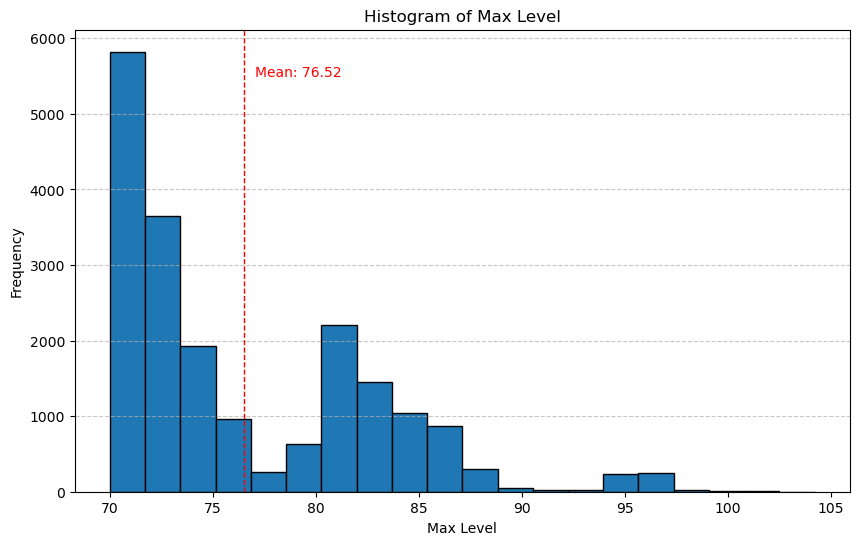

In [9]:
# Plot the histogram of the 'max_level' column
plt.figure(figsize=(10, 6))
plt.hist(df['max_level'].dropna(), bins=20, edgecolor='black')

# Add labels and title
plt.xlabel('Max Level')
plt.ylabel('Frequency')
plt.title('Histogram of Max Level')
plt.axvline(df['max_level'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.text(df['max_level'].mean() + 0.5, plt.ylim()[1]*0.9, 'Mean: {:.2f}'.format(df['max_level'].mean()), color='red')

# Show the grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()

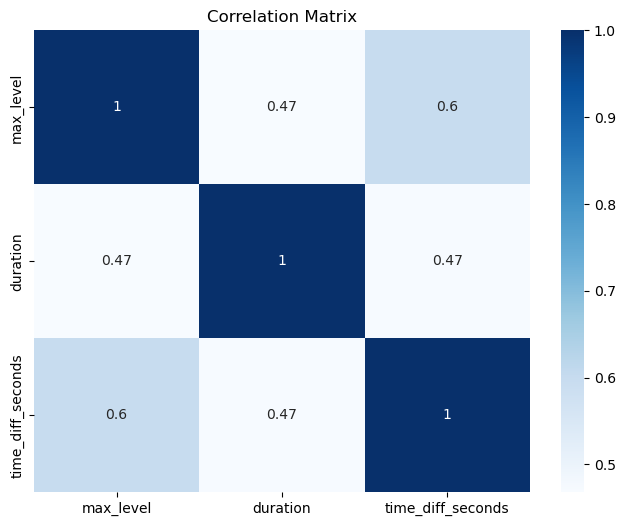

In [10]:
# Select only the relevant numerical columns
numerical_columns = ['max_level', 'duration', 'time_diff_seconds']
df_subset = df[numerical_columns]

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df_subset.corr(), annot=True, cmap='Blues')
plt.title('Correlation Matrix')
plt.show()



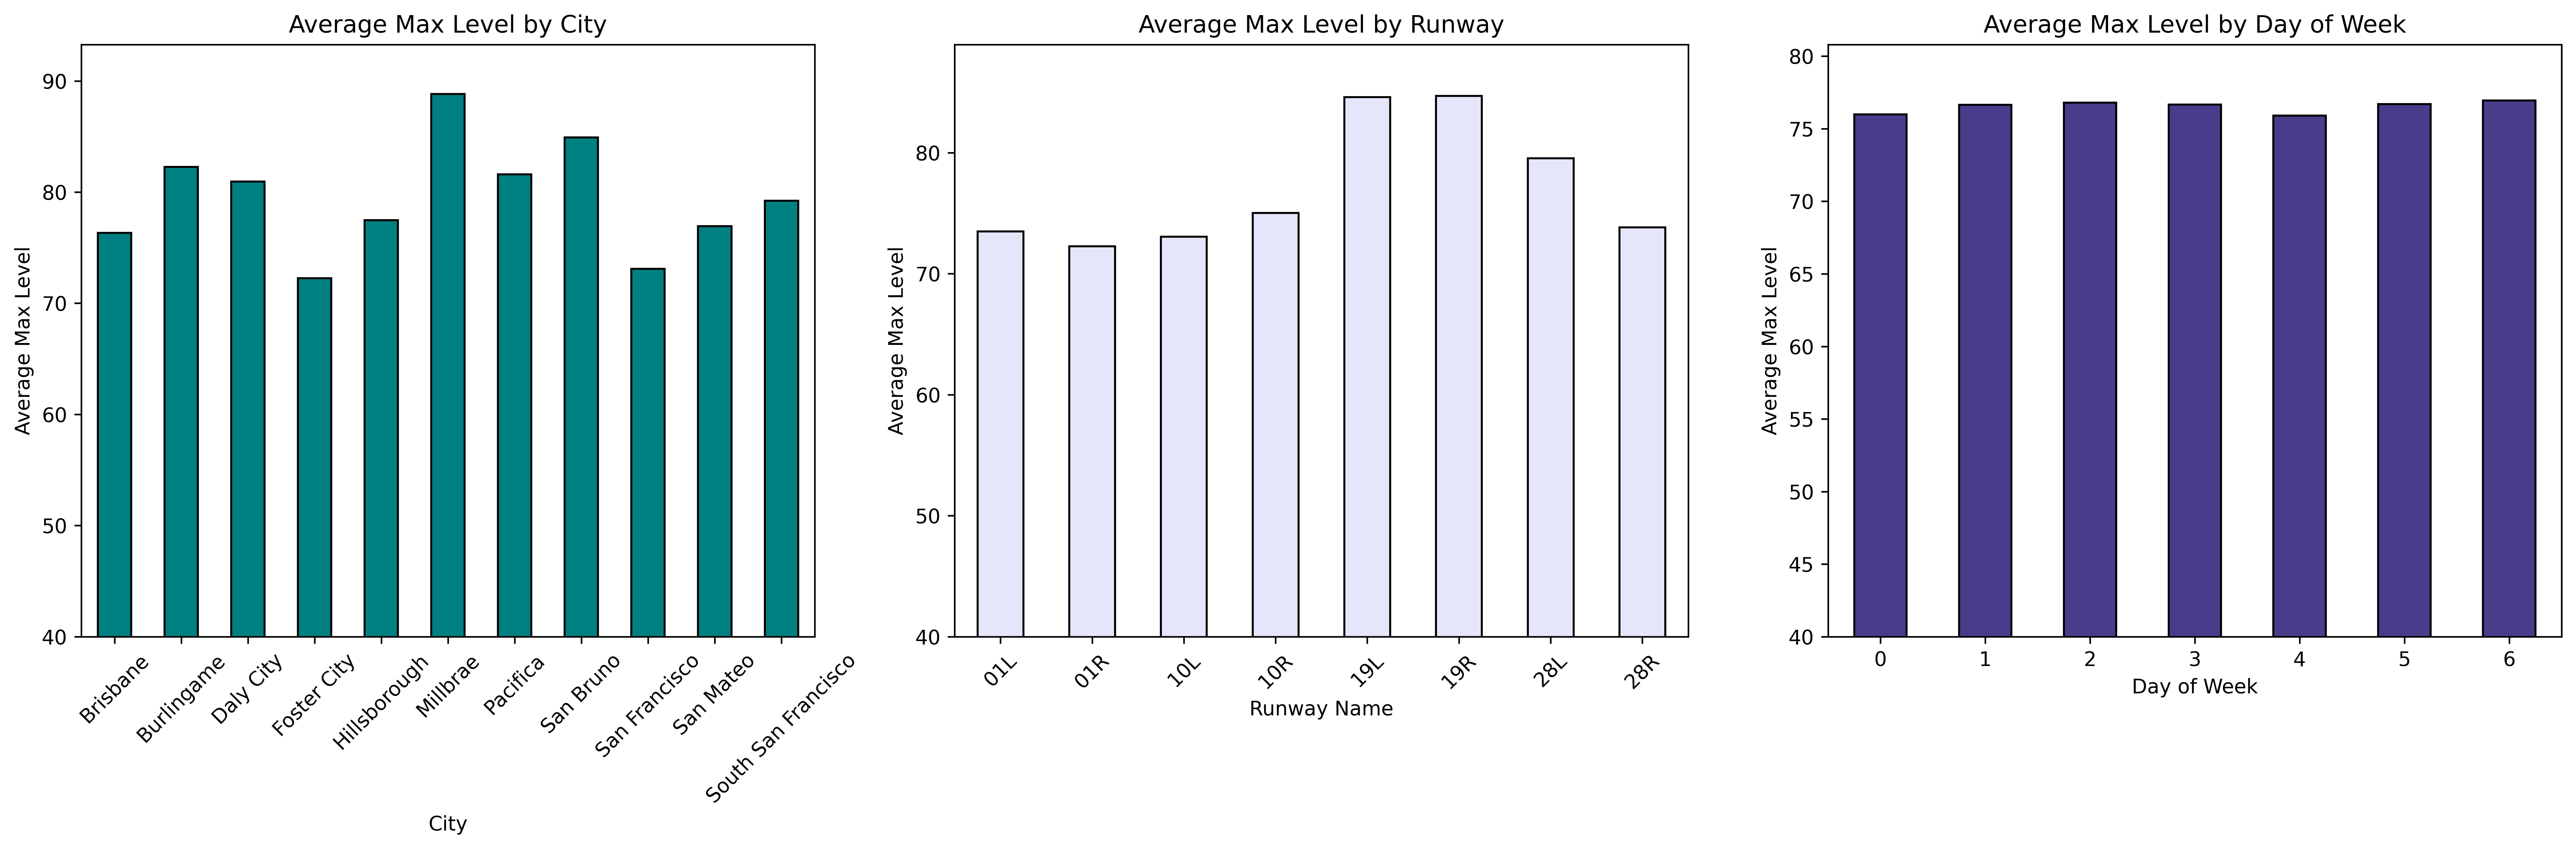

In [11]:
# Group by city, runway_name, and day_of_week and calculate average max_level
avg_by_city = df.groupby('city')['max_level'].mean()
avg_by_runway = df.groupby('runway_name')['max_level'].mean()
avg_by_day = df.groupby('day_of_week')['max_level'].mean()

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6),dpi = 600)

# Plot 1: Average max_level by city
avg_by_city.plot(kind='bar', ax=axes[0], color='teal', edgecolor='black')
axes[0].set_title('Average Max Level by City')
axes[0].set_xlabel('City')
axes[0].set_ylabel('Average Max Level')
axes[0].set_ylim(40)  # Set y-axis start to 40
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Average max_level by runway_name
avg_by_runway.plot(kind='bar', ax=axes[1], color='lavender', edgecolor='black')
axes[1].set_title('Average Max Level by Runway')
axes[1].set_xlabel('Runway Name')
axes[1].set_ylabel('Average Max Level')
axes[1].set_ylim(40)  # Set y-axis start to 40
axes[1].tick_params(axis='x', rotation=45)

# Plot 3: Average max_level by day_of_week
avg_by_day.plot(kind='bar', ax=axes[2], color='darkslateblue', edgecolor='black')
axes[2].set_title('Average Max Level by Day of Week')
axes[2].set_xlabel('Day of Week')
axes[2].set_ylabel('Average Max Level')
axes[2].set_ylim(40)  # Set y-axis start to 40
axes[2].tick_params(axis='x', rotation=0)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

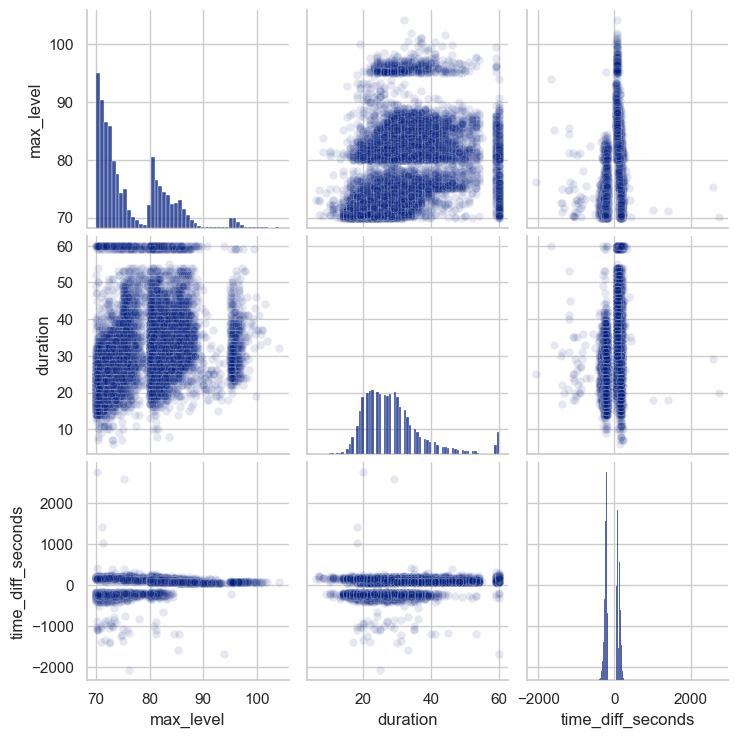

In [12]:
# Set style and palette
sns.set(style="whitegrid", palette="dark")

# Create scatter plots with transparency
sns.pairplot(df_subset, plot_kws={'alpha': 0.1})

# Display the plots
plt.show()

In [13]:
# Define features (X) and target (y)
X = df.drop(columns=['max_level'])
y = df['max_level']

X = pd.get_dummies(X, columns=['city','runway_name', 'aircraft_type', 'aircraft_category', 
                               'airline_code', 'other_port','day_night','day_of_week','month'],drop_first=True)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")

# Display model coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
print("\nModel Coefficients:")
print(coefficients.sort_values(by='Coefficient', ascending=False))

Mean Squared Error (MSE): 6.29
R² Score: 0.84

Model Coefficients:
              Feature  Coefficient
6       city_Millbrae    11.761496
15    runway_name_19L     6.777641
14    runway_name_10R     6.593997
237    other_port_SFO     6.491216
8      city_San Bruno     6.301497
..                ...          ...
70   airline_code_AFR    -2.026067
82   airline_code_CJT    -2.285479
80   airline_code_CES    -4.120651
4    city_Foster City    -5.068075
259   day_night_Night    -8.367242

[277 rows x 2 columns]


In [14]:
# Define features (X) and target (y)
X = df.drop(columns=['max_level'])
y = df['max_level']

# One-Hot Encode categorical features
X = pd.get_dummies(X, columns=['city','runway_name', 'aircraft_type', 'aircraft_category', 
                               'airline_code', 'other_port','day_night','day_of_week','month'])

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Decision Tree Regressor (CART model)
model = DecisionTreeRegressor(random_state=42)

# Train the model
model.fit(X_train, y_train)
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")


Mean Squared Error (MSE): 6.31
R² Score: 0.84


In [ ]:
# Plot the tree
plt.figure(figsize=(20, 10),dpi=800)
plot_tree(model, 
          feature_names=X.columns, 
          filled=True, 
          rounded=True, 
          fontsize=10,
         max_depth=3)
plt.title("Decision Tree Visualization")
plt.show()

In [16]:
# Define features (X) and target (y)
X = df.drop(columns=['max_level'])
y = df['max_level']

# One-Hot Encode categorical features
X = pd.get_dummies(X, columns=['city','runway_name', 'aircraft_type', 'aircraft_category', 
                               'airline_code', 'other_port','day_night','day_of_week','month'])

# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

# Set up GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='r2')

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 200}
Mean Squared Error (MSE): 3.31
R² Score: 0.92


In [17]:
# Define features (X) and target (y)
X = df.drop(columns=['max_level'])
y = df['max_level']

# One-Hot Encode categorical features
X = pd.get_dummies(X, columns=['city','runway_name', 'aircraft_type', 'aircraft_category', 
                               'airline_code', 'other_port','day_night','day_of_week','month'])

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the XGBoost Regressor
xgb = XGBRegressor(random_state=42)

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Set up GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='r2')

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
Mean Squared Error (MSE): 3.20
R² Score: 0.92
